## Imports

In [32]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px # this is another plotting library for interactive plot

from sklearn.model_selection import train_test_split
from sklearn import metrics, manifold # we will use the metrics and manifold learning modules from scikit-learn
from pathlib import Path # to interact with file paths
from PIL import Image # to interact with images
from tqdm import tqdm # progress bar
from pprint import pprint # pretty print (useful for a more readable print of objects like lists or dictionaries)
from IPython.display import clear_output # to clear the output of the notebook

import torch
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import os
import shutil


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")

cuda


In [33]:
# CONTROL
# NOTE : Sign detecttion uses the folder training_images to load the backgrounds
# it uses the folder sign_imgs to load the signs, the rate of examples is important
num_channels = 3 # COLOR IMGS
SIZE = (16, 16)
model_name = 'models/sign_classifier.pt'
onnx_sign_classifier_path = "models/sign_classifier.onnx"
max_load = 1_000 


In [34]:
# LOAD EXAMPLES
# imgs of the examples must be in a specific folder (ex: sign_imgs), and must be named as "class_<number>.png"
# ex: sign_imgs/stop_1.png, note: start from 1

#load examples
examples_folder = 'sign_imgs'     
# class_names = ['park', 'closedroad', 'highwayexit', 'highwayenter', 'stop', 'roundabout', 'priority', 'crosswalk', 'oneway', 'trafficlight', 'nosign'] 
class_names = ['park', 'closedroad', 'highwayexit', 'highwayenter', 'stop', 'roundabout', 'priority', 'crosswalk', 'oneway', 'trafficlight', 'nosign']  # with traffic_light

# class_names = ['park', 'closedroad', 'highwayexit', 'highwayenter', 'stop', 'roundabout', 'priority', 'crosswalk', 'oneway']

file_names = [f for f in os.listdir(examples_folder) if f.endswith('.png')]
example_labels = [class_names.index(name.split('_')[0]) for name in file_names if name.split('_')[0] in class_names]
example_imgs = [cv.resize(cv.blur(cv.imread(os.path.join(examples_folder, name)), (5,5)), (128,128)) for name in file_names if name.split('_')[0] in class_names]
tot_examples = len(example_imgs)
tot_classes = len(class_names) 
print(f'{tot_examples} examples loaded for {tot_classes} class_names')
print(f'example labels: {example_labels}')    

#show images
cv.namedWindow('example', cv.WINDOW_NORMAL)
for i in range(tot_examples):
    img = example_imgs[i].copy()
    # add text label
    cv.putText(img, class_names[example_labels[i]], (10,30), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv.imshow('example', img)
    key = cv.waitKey(1)
    if key == 27:
        break
cv.destroyAllWindows()     

42 examples loaded for 11 class_names
example labels: [10, 4, 8, 10, 10, 7, 6, 10, 10, 10, 5, 9, 5, 10, 9, 2, 6, 10, 1, 7, 1, 0, 8, 3, 10, 4, 2, 9, 8, 7, 0, 4, 6, 3, 0, 10, 5, 1, 10, 2, 10, 3]


In [35]:
# # NETWORK ARCHITECTURE 32x32

# class SignClassifier(nn.Module):
#     def __init__(self, out_dim=4, channels=num_channels): 
#         super().__init__()
#         p = 0.2
#         ### Convoluational layers
#         self.conv = nn.Sequential( #in = (SIZE)
#             nn.Conv2d(channels, 16, kernel_size=3, stride=1), #out = 12 - 28  
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=2, stride=2), #out=10 - 14
#             nn.BatchNorm2d(16),
#             nn.Dropout(p),
#             nn.Conv2d(16, 8, kernel_size=4, stride=2), #out = 6
#             nn.ReLU(True),
#             nn.Dropout(p),
#             nn.MaxPool2d(kernel_size=2, stride=1), #out=5
#             # nn.BatchNorm2d(4),
#             nn.Dropout(p),
#             nn.Conv2d(8, 64, kernel_size=5, stride=1), #out = 1
#             nn.ReLU(True),
#             nn.Dropout(p),
#         )
#         self.flat = nn.Flatten()
#         ### Linear sections
#         self.lin = nn.Sequential(
#             # First linear layer
#             # nn.Linear(in_features=4*4*4, out_features=128),
#             # nn.ReLU(True),
#             # nn.Dropout(p),
#             # nn.Linear(in_features=128, out_features=out_dim),
#             nn.Linear(in_features=64*1*1, out_features=out_dim),
#         )
        
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.flat(x)
#         x = self.lin(x)
#         return x

# sign_classifier = SignClassifier(out_dim=tot_classes,channels=num_channels).to(device)

In [36]:
# NETWORK ARCHITECTURE 16x16

class SignClassifier(nn.Module):
    def __init__(self, out_dim=4, channels=num_channels): 
        super().__init__()
        p = 0.3
        ### Convoluational layers
        self.conv = nn.Sequential( #in = (SIZE)
            nn.Conv2d(channels, 16, kernel_size=5, stride=1), #out = 12
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=1), #out=10
            nn.BatchNorm2d(16),
            nn.Dropout(p),
            nn.Conv2d(16, 16, kernel_size=5, stride=1), #out = 6
            nn.ReLU(True),
            nn.Dropout(p),
            nn.MaxPool2d(kernel_size=2, stride=1), #out=5
            # nn.BatchNorm2d(4),
            nn.Dropout(p),
            nn.Conv2d(16, 64, kernel_size=5, stride=1), #out = 1
            nn.ReLU(True),
            nn.Dropout(p),
        )
        self.flat = nn.Flatten()
        ### Linear sections
        self.lin = nn.Sequential(
            # First linear layer
            # nn.Linear(in_features=4*4*4, out_features=128),
            # nn.ReLU(True),
            # nn.Dropout(p),
            # nn.Linear(in_features=128, out_features=out_dim),
            nn.Linear(in_features=64*1*1, out_features=out_dim),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.lin(x)
        return x

sign_classifier = SignClassifier(out_dim=tot_classes,channels=num_channels).to(device)

In [37]:
# TEST NET INPUTS/OUTPUTS
#show the image with opencv
img = cv.imread('tests/test_img.jpg')
img = cv.resize(img, SIZE)
if num_channels == 1:
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = np.expand_dims(img, axis=2)
#convert to tensor
img = torch.from_numpy(img).float()
img = img.permute(2,0,1)
#add dimension
img = img.unsqueeze(0).to(device)
print(img.shape)

sign_classifier.eval()

# Inference
with torch.no_grad():
    output = sign_classifier(img)
    print(f'out shape: {output.shape}')

torch.Size([1, 3, 16, 16])
out shape: torch.Size([1, 11])


## Loading images and Labels

In [38]:
# #load coco dataset and create background img in the background folder

# import json

# MAX_BACKGROUNDS = 500_000

# #get all file names inside fodler sign_imgs/coco_val
# # coco_val_img_names = [os.path.join('sign_imgs', 'coco_val', f) for f in os.listdir(os.path.join('sign_imgs', 'coco_val'))]
# coco_val_img_names = [f for f in os.listdir(os.path.join('sign_imgs', 'coco_val'))]

# print(f'{len(coco_val_img_names)} images in coco val')

# #get all instances
# #load json file
# with open('sign_imgs/coco_val/instances_val2017.json') as f:
#     data = json.load(f)
#     #print name of the file
#     print(f'images = {len(data["images"])}')
#     print(f'annotations = {len(data["annotations"])}')


#     categories = {cat['id']:cat['name'] for cat in data['categories']}
#     categories_by_name = {cat['name']:cat['id'] for cat in data['categories']}

#     filtered_categories = ['traffic light', 'bicycle', 'car', 'motorcycle', 'bus', 'truck',
#                             'fire hydrant', 'stop sign',  'parking meter']
#     filtered_categories_idxs = [categories_by_name[c] for c in filtered_categories]

#     img_names_by_id = {img['id']:img['file_name'] for img in data['images']}

#     categ_by_id = {img['id']:[] for img in data['images']}

#     for ann in data['annotations']:
#         categ_id = ann['category_id']
#         img_id = ann['image_id']
#         if img_id in categ_by_id:
#             categ_by_id[img_id].append(categories[categ_id])
#         if categ_id in filtered_categories_idxs:
#             img_names_by_id.pop(img_id, None)
#             categ_by_id.pop(img_id, None)
    
#     for id, c in categ_by_id.items():
#         if len(c) == 0:
#             img_names_by_id.pop(id, None)

#     print(f'final images = {len(img_names_by_id)}')

#     BACKGROUND_SIZE = (320,240)
#     idx = 0
#     for k, img_name in img_names_by_id.items():
#         img_name = img_names_by_id[k]
#         categories_in_img = categ_by_id[k]
#         img = cv.imread(os.path.join('sign_imgs', 'coco_val', img_name))
#         img = cv.resize(img, (2*BACKGROUND_SIZE[0], 2*BACKGROUND_SIZE[1]))
#         #divide the image into 4 parts
#         img_parts = [img[:BACKGROUND_SIZE[1], :BACKGROUND_SIZE[0]],
#                     img[:BACKGROUND_SIZE[1], BACKGROUND_SIZE[0]:],
#                     img[BACKGROUND_SIZE[1]:, :BACKGROUND_SIZE[0]],
#                     img[BACKGROUND_SIZE[1]:, BACKGROUND_SIZE[0]:]]

#         for i in range(4):
#             img_part = img_parts[i]
#             #further divide the image into 4 parts
#             img_part_parts = [img_part[:BACKGROUND_SIZE[1]//2, :BACKGROUND_SIZE[0]//2],
#                             img_part[:BACKGROUND_SIZE[1]//2, BACKGROUND_SIZE[0]//2:],
#                             img_part[BACKGROUND_SIZE[1]//2:, :BACKGROUND_SIZE[0]//2],
#                             img_part[BACKGROUND_SIZE[1]//2:, BACKGROUND_SIZE[0]//2:]]
#             for j in range(4):
#                 img_part_part = img_part_parts[j]
#                 cv.imshow(f'img_{i}{j}', img_part_parts[j])
#                 idx += 1
#                 cv.imwrite(os.path.join('sign_imgs', 'backgrounds', f'background_{idx}.png'), img_part_parts[j])

#         print(f'{categories_in_img}')
#         key = cv.waitKey(1)
#         if key == 27 or idx > MAX_BACKGROUNDS:
#             break

# cv.destroyAllWindows()


In [39]:
# IMG LOADER AND AUGMENTATION
import cv2 as cv
import numpy as np
from numpy.random import randint

def draw_box(img, x, y, w):
    img = cv.rectangle(img, (int(x-w/2), int(y-w/2)), (int(x+w/2), int(y+w/2)), 255, 2)
    return img

def load_and_augment_img(img, example_index=0, example_imgs=example_imgs):
    # img = cv.imread(os.path.join(folder, f'img_{i+1}.png'))
    if img is not None:
        #convert to gray
        # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # #crop to the top right quadrant
        img = img[0:img.shape[1]//2, img.shape[1]//2:]
        canv_dim = randint(64//2, 240//2)  ## RANGE OF DIMENSION OF THE SIGN
        start_x = randint(0, img.shape[1]-canv_dim) if img.shape[1] > canv_dim else 0
        start_y = randint(0, img.shape[0]-canv_dim) if img.shape[0] > canv_dim else 0
        img = img[start_y:start_y+canv_dim, start_x:start_x+canv_dim]
        # img = cv.resize(img, (2*SIZE[0], 2*SIZE[1]))
    else:
        img = randint(0,255,(2*SIZE[0], 2*SIZE[1]), dtype=np.uint8)


    background_avg_brightness = np.mean(img)

    ## EXAMPLE AUGMENTATION ##############################################################
    #load example
    example = example_imgs[example_index]
    resize_ratio = max(img.shape)/max(example.shape)
    example = cv.resize(example, (int(example.shape[1]*resize_ratio), int(example.shape[0]*resize_ratio)))
    #Make a black border aroud the example
    example[0:2,:,:] = np.array([0,0,0])
    example[-3:-1,:,:] = np.array([0,0,0])
    example[:,0:2,:] = np.array([0,0,0])
    example[:,-3:-1,:] = np.array([0,0,0])

    #get example mask
    example_mask = np.where(example == np.array([0,0,0]), np.zeros_like(example), 255*np.ones_like(example))
    example_mask = example_mask.astype(np.uint8)
    example_mask = cv.cvtColor(example_mask, cv.COLOR_BGR2GRAY)
    #convert to bitmap
    example_mask = np.where(example_mask == 0, 0, 255)
    example_mask = example_mask.astype(np.uint8)
    #back to BGR
    example_mask = cv.cvtColor(example_mask, cv.COLOR_GRAY2BGR)
    
    # add noise to the example
    std = 20
    std = randint(1, std)
    noisem = randint(0, std, example.shape, dtype=np.uint8)
    example = cv.subtract(example, noisem)
    noisep = randint(0, std, example.shape, dtype=np.uint8)
    example = cv.add(example, noisep)

    #set zero where example mask is zero
    example = np.where(example_mask == np.array([0,0,0]), np.zeros_like(example), example)

    #perspective transform example
    perspective_deformation = img.shape[0]//8 ################# DEFORMATION
    pts1 = np.float32([[0,0],[example.shape[1],0],[example.shape[1],example.shape[0]],[0,example.shape[0]]])
    pts2 = np.float32([[0,0],[example.shape[1],0],[example.shape[1],example.shape[0]],[0,example.shape[0]]])
    pts2 = pts2 + np.float32(randint(0,perspective_deformation,size=pts2.shape))
    # print(f'pts2 = \n{pts2}')
    new_size_x = int(np.max(pts2[:,0]) - np.min(pts2[:,0]))
    new_size_y = int(np.max(pts2[:,1]) - np.min(pts2[:,1]))
    M = cv.getPerspectiveTransform(pts1,pts2)
    example = cv.warpPerspective(example,M,(new_size_x,new_size_y))

    #resize example keeping proportions
    img_example_ratio = min(img.shape[0]/example.shape[0], img.shape[1]/example.shape[1])
    scale_factor = np.random.uniform(.5, .98) ##.15, .35############################ PARAM ##############################
    scale_factor = scale_factor * img_example_ratio
    example = cv.resize(example, (0,0), fx=scale_factor, fy=scale_factor)
    #match img shape
    example_canvas = np.zeros((img.shape[0], img.shape[1], num_channels), dtype=np.uint8)

    #get a random position for the example
    example_y = randint(0, img.shape[0] - example.shape[0])
    example_x = randint(0, img.shape[1] - example.shape[1])
    #paste example on canvas
    example_canvas[example_y:example_y+example.shape[0], example_x:example_x+example.shape[1]] = example

    #canvas mask
    example_canvas_mask = example_canvas.copy()
    example_canvas_mask = cv.cvtColor(example_canvas_mask, cv.COLOR_BGR2GRAY)
    example_canvas_mask = np.where(example_canvas_mask == 0, 0, 255)
    example_canvas_mask = example_canvas_mask.astype(np.uint8)
    edge_of_canvas = cv.Canny(example_canvas_mask, 100, 200)
    ker_rand = randint(2,5)
    edge_of_canvas = cv.dilate(edge_of_canvas, np.ones((ker_rand,ker_rand)))
    #erode mask
    ker_rand = randint(2,5) if SIZE == (32,32) else randint(1,3)
    kernel = np.ones((ker_rand,ker_rand),np.uint8)
    iter_rand = randint(1,3) if SIZE == (32,32) else randint(1,2)
    example_canvas_mask = cv.erode(example_canvas_mask,kernel,iterations=iter_rand)

    #convert to hsv
    example_canvas = cv.cvtColor(example_canvas, cv.COLOR_BGR2HSV)
    #get the hsv channels
    example_canvas_h = example_canvas[:,:,0]
    example_canvas_s = example_canvas[:,:,1]
    example_canvas_v = example_canvas[:,:,2]

    # #reduce brightness
    example_avg_brightness = np.mean(example_canvas_v)
    if example_avg_brightness > 0.0:
        example_avg_brightness = np.mean(example_canvas_v, where=example_canvas_v>0)
    diff = -example_avg_brightness +background_avg_brightness
    brightness_shift = int(round(diff) + randint(-80,80))
    brightness_shift = np.clip(brightness_shift, -255, 255)
    # example_canvas_v = np.clip(example_canvas_v + brightness_shift, 0, 255).astype(np.uint8)
    if brightness_shift > 0:
        example_canvas_v = cv.add(example_canvas_v, np.ones_like(example_canvas_v)*brightness_shift)
    elif brightness_shift < 0:
        example_canvas_v = cv.subtract(example_canvas_v, np.ones_like(example_canvas_v)*abs(brightness_shift))

    #reduce contrast
    const = np.random.uniform(0.25,.9)
    example_canvas_v = np.clip(127*(1-const) + example_canvas_v*const, 0, 255).astype(np.uint8)

    #augment hue
    hue_shift = randint(-7,7)
    example_canvas_h = (example_canvas_h + hue_shift) % 180

    #augment saturation
    sat_shift = randint(-120,0)
    example_canvas_s = np.clip(example_canvas_s + sat_shift, 0, 255).astype(np.uint8)

    #rebuild the channels
    example_canvas[:,:,0] = example_canvas_h
    example_canvas[:,:,1] = example_canvas_s
    example_canvas[:,:,2] = example_canvas_v
    #back to bgr
    example_canvas = cv.cvtColor(example_canvas, cv.COLOR_HSV2BGR)

    #paste canvas on img
    img_b = img[:,:,0]
    img_g = img[:,:,1]
    img_r = img[:,:,2]
    example_b = example_canvas[:,:,0]
    example_g = example_canvas[:,:,1]
    example_r = example_canvas[:,:,2]
    img_b = np.where(example_canvas_mask > 0, example_b, img_b)
    img_g = np.where(example_canvas_mask > 0, example_g, img_g)
    img_r = np.where(example_canvas_mask > 0, example_r, img_r)
    # img = np.where(example_canvas_mask > 0, example_canvas, img) 
    img[:,:,0] = img_b
    img[:,:,1] = img_g
    img[:,:,2] = img_r

    ker_rand = randint(2,5)
    blurred_img = cv.blur(img, (ker_rand,ker_rand))
    img = np.where(edge_of_canvas ==np.array([0,0,0]), blurred_img, img)

    ##########################################################################################
    
    # convert whole img to hsv
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    #get the hsv channels
    img_h = img[:,:,0]
    img_s = img[:,:,1]
    img_v = img[:,:,2]

    #reduce contrast
    const = np.random.uniform(0.5,.99)
    img_v = np.clip(127*(1-const) + img_v*const, 0, 255).astype(np.uint8)

    #reduce brightness
    brightness_shift = randint(-40,0)
    if brightness_shift > 0:
        img_v = cv.add(img_v, np.ones_like(img_v)*brightness_shift)
    elif brightness_shift < 0:
        img_v = cv.subtract(img_v, np.ones_like(img_v)*abs(brightness_shift))

    #augment hue
    hue_shift = randint(-2,2)
    img_h = (img_h + hue_shift) % 180

    #augment saturation
    sat_shift = randint(-20,0)
    img_s = np.clip(img_s + sat_shift, 0, 255).astype(np.uint8)

    #rebuild the channels
    img[:,:,0] = img_h
    img[:,:,1] = img_s
    img[:,:,2] = img_v
    #back to bgr
    img = cv.cvtColor(img, cv.COLOR_HSV2BGR)


    #add random tilt
    max_offset = img.shape[0]//4
    offset = np.random.randint(-max_offset, max_offset)
    # img = np.roll(img, offset, axis=0)
    if offset > 0:
        # img[:offset, :] = np.random.randint(0,255)
        img = img[offset:, :]
    elif offset < 0:
        # img[offset:, :] = np.random.randint(0,255)
        img = img[:offset, :]

    offset_y = np.random.randint(-max_offset, max_offset)
    # img = np.roll(img, offset_y, axis=1)
    if offset_y > 0:
        # img[:, :offset_y] = np.random.randint(0,255)
        img = img[:, offset_y:]
    elif offset_y < 0:
        # img[:, offset_y:] = np.random.randint(0,255)
        img = img[:, :offset_y]

    min_dim = min(img.shape[0], img.shape[1])
    #crop to square
    img = img[:min_dim, :min_dim]

    #add noise
    std = 50
    std = randint(1, std)
    noisem = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.subtract(img, noisem)
    noisep = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.add(img, noisep)


    # # crop into the img at random position
    # zoom = randint(0, SIZE[0]//4)
    # img = img[zoom:img.shape[0]-zoom, zoom:img.shape[1]-zoom]

    #blur 
    b = randint(1,4) 
    img = cv.blur(img, (b,b))
    
    img = cv.resize(img, SIZE)

    #convert to hsv
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    return img


cv.namedWindow('img', cv.WINDOW_NORMAL)
# cv.setWindowProperty('img', cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN)

for i in range(500):
    img = cv.imread(os.path.join('sign_imgs', 'backgrounds',  f'background_{i+1}.png'))
    # img = cv.resize(img, (160,120))
    # img = None
    img = load_and_augment_img(img, example_index=(i%tot_examples))

    #to bgr
    img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
    cv.imshow('img', img)
    key = cv.waitKey(200)
    if key == ord('q') or key == 27:
        break
cv.destroyAllWindows()

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:155: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [40]:
# DATASET CLASS
class CsvDataset(Dataset):
    def __init__(self, transform=None, max_load=1000, channels=3):
        self.transform = transform
        self.folder = os.path.join('sign_imgs', 'backgrounds')
        self.data = []
        self.class_names = []
        self.channels = channels
        self.all_imgs = torch.zeros((max_load*tot_examples, SIZE[1], SIZE[0], channels), dtype=torch.uint8)

        cv.namedWindow('img', cv.WINDOW_NORMAL)
        # cv.setWindowProperty('img', cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN

        for i in tqdm(range(max_load)):
            img = cv.imread(os.path.join(self.folder, f'background_{i+1}.png'))
            # img = cv.resize(img, (160,120))
            for j in range(tot_examples):
                img_j = load_and_augment_img(img.copy(), example_index=j)
                if i < 100:
                    cv.imshow('img', img_j)
                    cv.waitKey(1)
                    if i == 99:
                        cv.destroyAllWindows()
                #add a dimension to the image
                img_j = img_j[:, :,np.newaxis] if self.channels == 1 else img_j
                #convert to tensor
                img_j = torch.from_numpy(img_j)
                self.all_imgs[i*tot_examples+j] = img_j
                self.class_names.append(example_labels[j])
        
        self.data = torch.from_numpy(np.array(self.data))
        self.class_names = torch.from_numpy(np.array(self.class_names))
        print(f'\nall imgs: {self.all_imgs.shape}')
        print(f'class_names: {self.class_names.shape}')


    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.class_names)

    def __getitem__(self, idx):
        # img = read_image(os.path.join(self.folder, f'img_{idx+1}.png'))
        # img = img.float()
        img = self.all_imgs[idx]
        img = img.permute(2, 0, 1).float()
        class_label = self.class_names[idx]
        return img, class_label

In [41]:
#create dataset #takes a long time but then training is faster
train_dataset = CsvDataset(max_load=max_load, channels=num_channels)
#split dataset into train and val
train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

100%|██████████| 1000/1000 [02:45<00:00,  6.06it/s]


all imgs: torch.Size([42000, 16, 16, 3])
class_names: torch.Size([42000])


In [42]:
#data loader
train_dataloader = DataLoader(train_dataset, batch_size=5*8192//3, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8192//3, shuffle=False)

In [43]:
#test dataloader
sample = next(iter(train_dataloader))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([13653, 3, 16, 16])
torch.Size([13653])


## Training

In [44]:
# TRAINING FUNCTION
def train_epoch(model, dataloader, regr_loss_fn, class_loss_fn, optimizer, L1_lambda=0.0, L2_lambda=0.0,  device=device):
    # Set the model to training mode
    model.train() #train
    # Initialize the loss
    class_losses = []

    # Loop over the training batches
    for (input, class_label) in tqdm(dataloader):
        #one hot encode the class label
        class_label = torch.eye(tot_classes)[class_label]
        # Move the input and target data to the selected device
        input, class_label = input.to(device), class_label.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(input)

        #regression
        class_out = output[:, 0:]

        #classification loss
        assert class_label.shape == class_out.shape, f'class_label.shape: {class_label.shape}, output.shape: {output.shape}'

        class_loss = 1.0*class_loss_fn(class_out, class_label)

        #L1 regularization
        L1_norm = sum(p.abs().sum() for p in model.conv.parameters())
        L1_loss = L1_lambda * L1_norm 
        #L2 regularization
        L2_norm = sum(p.pow(2).sum() for p in model.conv.parameters())
        L2_loss = L2_lambda * L2_norm

        loss = class_loss + L1_loss + L2_loss

        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()

        class_losses.append(class_loss.detach().cpu().numpy())

    # Return the average training loss
    class_loss = np.mean(class_losses)
    return  np.sqrt(class_loss)

    # VALIDATION FUNCTION
def val_epoch(sign_classifier, val_dataloader, regr_loss_fn, class_loss_fn, device=device):
    sign_classifier.eval()
    y_losses = []
    x_losses = []
    w_losses = []
    class_losses = []
    for (input, class_label) in tqdm(val_dataloader):
        #one hot encode the class label
        class_label = torch.eye(tot_classes)[class_label]
        input, class_label = input.to(device), class_label.to(device)
        output = sign_classifier(input)

        class_loss = 1.0*class_loss_fn(output[:, 0:], class_label)
    
        class_losses.append(class_loss.detach().cpu().numpy())
    return  np.mean(class_losses)

In [45]:
# TRAINING 
#parameters
lr = 0.002 #0.005
epochs = 200 #50+
#regularization is applied only to convolutional section, add weight decay to apply it to all layers
L1_lambda = 1e-4 #9e-4
L2_lambda = 1e-3 #1e-2
optimizer = torch.optim.Adam(sign_classifier.parameters(), lr=lr, weight_decay=3e-5) #wd = 2e-3# 9e-5

regr_loss_fn = nn.MSELoss()
class_loss_fn = nn.CrossEntropyLoss()
best_val = 100
for epoch in range(epochs):
    try:
    # if True:
        class_loss = train_epoch(sign_classifier, train_dataloader, regr_loss_fn, class_loss_fn, optimizer, L1_lambda, L2_lambda, device)
        val_class_loss = val_epoch(sign_classifier, val_dataloader, regr_loss_fn, class_loss_fn, device)
        clear_output(wait=True)
    except Exception as e:
        print(e)
        torch.cuda.empty_cache()
        continue
    print(f"Epoch  {epoch+1}/{epochs}")
    print(f"class_loss: {class_loss:.4f} --- Val: {val_class_loss:.4f}")
    if val_class_loss < best_val:
        torch.save(sign_classifier.state_dict(), model_name)
        print(f'Model saved as {model_name}')
        best_val = val_class_loss

Epoch  200/200
class_loss: 0.4856 --- Val: 0.2572


In [46]:
# # EVALUATE ON TEST SET (UNSEEN DATA)
# val_dataloader2 = DataLoader(val_dataset, batch_size=1, shuffle=False)
# sign_classifier.load_state_dict(torch.load(model_name))
# sign_classifier.eval()
# for (input, class_label) in tqdm(val_dataloader2):
#     #convert img to numpy array
#     img = input[0].detach().cpu().numpy()[0]
#     #convert to sigle byte
#     img = img.astype(np.uint8)
#     input, box_label, class_label =input.to(device), box_label.to(device), class_label.to(device)
#     output = sign_classifier(input)
#     x = output[:, 0]
#     y = output[:, 1]
#     w = output[:, 2]
#     class_out = output[:, 3:]
#     # print(class_out)
#     class_out = torch.argmax(class_out, dim=1)
#     class_out = class_out.detach().cpu().numpy()
#     # print(f"Predicted class: {class_out[0]}, Actual class: {class_label[0]}")
#     class_out = class_out[0]
#     class_out = class_names[class_out]
#     true_class = class_names[class_label[0]]
#     img = draw_box(img, x, y, w)
#     #text for labels
#     img = cv.putText(img, f"True: {true_class}", (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
#     img = cv.putText(img, f"Pred: {class_out}", (10, 60), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

#     cv.imshow('img', img)
#     key = cv.waitKey(0)
#     if key == 27:
#         break
    
# cv.destroyAllWindows()


(16, 3, 5, 5)
(16, 16, 5, 5)
(64, 16, 5, 5)


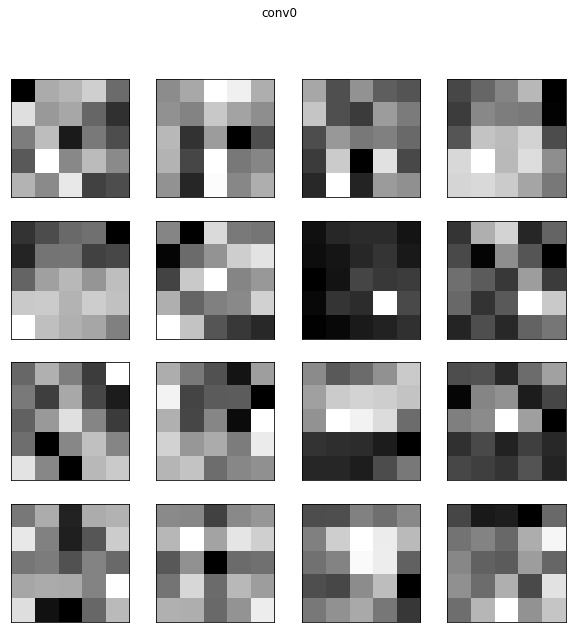

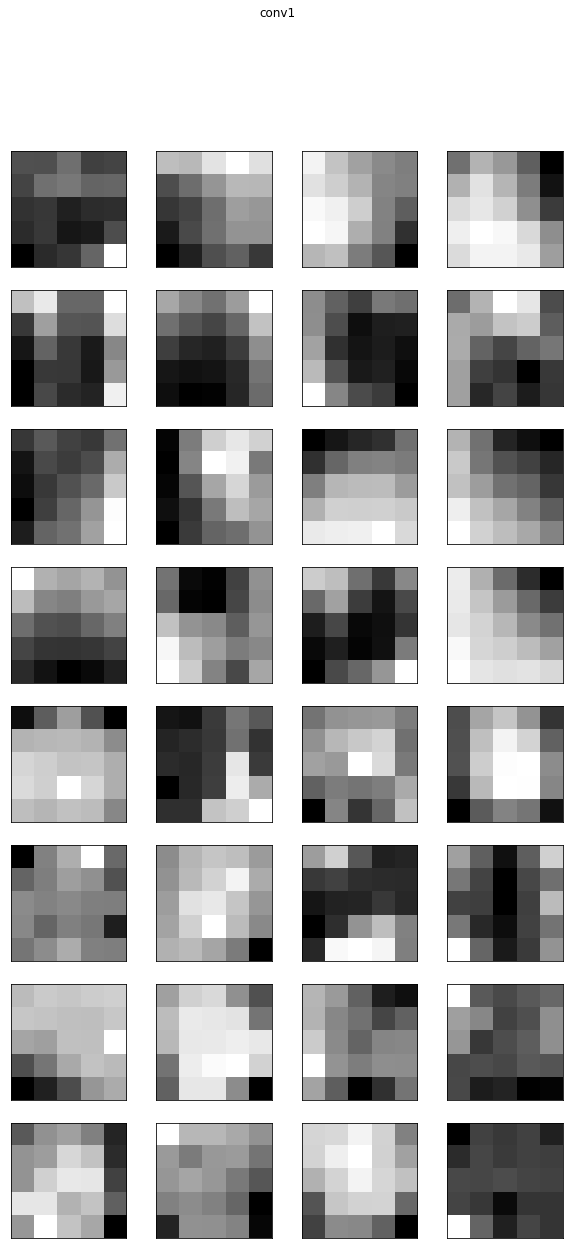

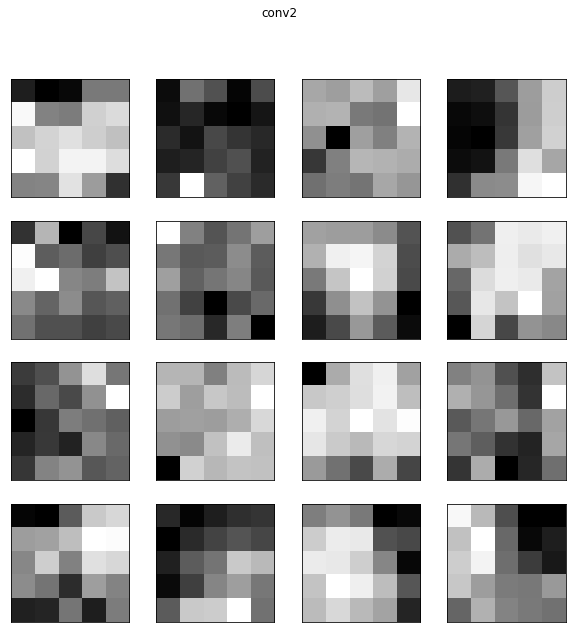

In [47]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(sign_classifier.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

c0 = conv_layers[0].weight.data.cpu().numpy()
c1 = conv_layers[1].weight.data.cpu().numpy()
c2 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c0.shape)
print(c1.shape)
print(c2.shape)

fig0 = plot_nchw_data(c0, 4, 4, 'conv0', size=(10,10))

fig1 = plot_nchw_data(c1, 8, 4, 'conv1', size=(10,20)) 

fig2 = plot_nchw_data(c2, 4, 4, 'conv2', size=(10,10))



In [48]:
# CONVERT TO ONNX MODEL FOR OPENCV
sign_classifier.load_state_dict(torch.load(model_name))

#save the model so that opencv can load it
import torch
import torch.onnx
import torchvision
import torchvision.models as models
import sys

device = torch.device('cpu')
sign_classifier.to(device)

# set the model to inference mode
sign_classifier.eval()

# Create some sample input in the shape this model expects 
# This is needed because the convertion forward pass the network once 
dummy_input = torch.randn(1, num_channels, SIZE[1], SIZE[0])
torch.onnx.export(sign_classifier, dummy_input, onnx_sign_classifier_path, verbose=True)

clear_output(wait=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sign_classifier.to(device)

SignClassifier(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Dropout(p=0.3, inplace=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [49]:
# TEST WITH OPENCV
sample_image = "training_imgs/img_1.png"
images = [cv.imread(f"training_imgs/img_{i+1}.png") for i in range(100)]
 
#The Magic:
lk =  cv.dnn.readNetFromONNX(onnx_sign_classifier_path) 

avg_col = (0,0,0) if num_channels == 3 else 0

for i in tqdm(range(100)):
    image = images[i]
    image = cv.resize(image, SIZE)
    if num_channels == 1:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blob = cv.dnn.blobFromImage(image, 1.0, SIZE, avg_col, swapRB=True, crop=False)
    # print(blob.shape)
    lk.setInput(blob)
    preds = lk.forward()
    # print(f"Predictions: {preds[0][2]}")

print(f"Predictions: {preds}")
print(f"Predictions shape: {preds.shape}")

100%|██████████| 100/100 [00:00<00:00, 823.64it/s]

Predictions: [[-19.194838    2.7842922  -4.7225633 -18.989916    4.6124454   8.458703
   -6.439257  -11.774608  -16.28502    -2.518611    4.2926397]]
Predictions shape: (1, 11)
